 # <center> MNIST classification </center>

The aim of this file is to train a two-layer neural network defined as [784, 400, 400, 10] using variarional bayes. The training dataset consistes of 50 thousands images containing hand-written characters. 10 thousands images are used to test the performance of the model after training.  

In [1]:
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
from tensorflow.examples.tutorials.mnist import input_data
import math
import matplotlib.patches as mpatches

import sklearn.model_selection as sk
from sklearn.model_selection import KFold, cross_val_score


from tempfile import TemporaryFile
from tensorflow.contrib.distributions import percentile

from Dataset import Dataset

/home/bashar/anaconda3/envs/conda_env/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
mnist = input_data.read_data_sets("MNIST_data/", one_hot=True)
# Placeholders for holding input and output 
x = tf.placeholder(tf.float32, [None, 784])  # None to fit any size of minibatch
y_=tf.placeholder(tf.float32,[None, 10])


Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.
Instructions for updating:
Please write your own downloading logic.
Instructions for updating:
Please use urllib or similar directly.
Successfully downloaded train-images-idx3-ubyte.gz 9912422 bytes.
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting MNIST_data/train-images-idx3-ubyte.gz
Successfully downloaded train-labels-idx1-ubyte.gz 28881 bytes.
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Instructions for updating:
Please use tf.one_hot on tensors.
Successfully downloaded t10k-images-idx3-ubyte.gz 1648877 bytes.
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Successfully downloaded t10k-labels-idx1-ubyte.gz 4542 bytes.
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz
Instructions for updating:
Please use alternatives such as official/mnist/dataset.py fr

In [3]:
####################################################################################
################ Training: Validation: Testing= 50k, 10k, 10k images ######################
####################################################################################

### Image normalization

train_x=mnist.train.images
train_y=mnist.train.labels

valid_x1=mnist.validation.images 
valid_y1=mnist.validation.labels  

test_x=mnist.test.images 
test_y=mnist.test.labels


l=np.shape(train_x)
m=np.mean(train_x,axis=1)
s=np.std(train_x,axis=1)
y=np.zeros(l)
for i in range(l[0]):
    y[i]=(train_x[i]-m[i])/s[i]
train_x=y.astype('float32')

l=np.shape(valid_x1)
m=np.mean(valid_x1,axis=1)
s=np.std(valid_x1,axis=1)
y=np.zeros(l)

for i in range(l[0]):
    y[i]=(valid_x1[i]-m[i])/s[i]
valid_x1=y.astype('float32')

l=np.shape(test_x)
m=np.mean(test_x,axis=1)
s=np.std(test_x,axis=1)
y=np.zeros(l)
for i in range(l[0]):
    y[i]=(test_x[i]-m[i])/s[i]
test_x=y.astype('float32')


train_x, valid_x2,train_y, valid_y2=sk.train_test_split(train_x,  train_y,  test_size=0.09090, random_state = 42, shuffle=True, stratify=train_y)

valid_x=np.concatenate((valid_x1, valid_x2))
valid_y=np.concatenate((valid_y1, valid_y2))

dataset= Dataset(train_x, train_y)  # create an object of the class Dataset to generate a next batch 


In [4]:
# Network structure
n_input=784
n_hidden=400  # for 2 hidden layers
n_output=10


# define network weight shapes
n_layers=2
# define network weight shapes
layer_param_shapes = []
for i in range(n_layers + 1):
    if i == 0: # input layer
        W_shape = [n_input, n_hidden]
        b_shape = [n_hidden]
    elif i == n_layers: # last layer
        W_shape = [n_hidden, n_output]
        b_shape = [n_output]
    else: # hidden layers
        W_shape = [n_hidden, n_hidden]
        b_shape = [n_hidden]
    layer_param_shapes.append(W_shape)
    layer_param_shapes.append(b_shape)


# Compute the network output
def net(x, layer_params): # layer_params=[w1,b1,w2,b2,w3,b3]
    act1=tf.nn.relu(tf.matmul(x,layer_params[0])+layer_params[1]) 
    act2=tf.nn.relu(tf.matmul(act1,layer_params[2])+layer_params[3])
    act3=tf.matmul(act2,layer_params[4])+layer_params[5]
    output=act3

    return output



In [5]:
# loglikelihood (cross entropy)
def error_loss(nn_output, labels):
    return tf.reduce_sum(tf.nn.softmax_cross_entropy_with_logits(logits=nn_output, labels=labels))

def log_gauss(x,mu=0.,sigma=0.367): 
    dist=tf.distributions.Normal(loc=mu, scale=sigma)
    return dist.log_prob(x)

# complexity loss= logq(w)-logp(w)
def complexity_loss(params, mus, sigmas):
    log_prior=tf.reduce_sum([tf.reduce_sum(log_gauss(param)) for param in params])
    log_variational=tf.reduce_sum([tf.reduce_sum(log_gauss(params[j],mus[j], sigmas[j])) for j in range(len(mus))])
    return log_variational-log_prior


In [6]:
# Trainable parametrs: The parameters of the variational distribution
mus=[tf.Variable(tf.random_normal(shape, mean=0.0,stddev=0.05,dtype=tf.float32)) for shape in layer_param_shapes]

rhos=[tf.Variable(tf.random_normal(shape, mean=-3., stddev=0.1,dtype=tf.float32)) for shape in layer_param_shapes]
sigmas=[tf.exp(rho) for rho in rhos]


In [7]:
## computing the unbiased estimate of the objective function using Monte Carlo Integration
# n_samples is the number of samples drawn from the variational distribution and used to compute the above estimate. 
N=128 # batch size
total_batch = int(mnist.train.num_examples/N)

n_samples=1
layer_params=[[]]*n_samples
output=[[]]*n_samples
loss1=[[]]*n_samples
loss2=[[]]*n_samples

for s in range(n_samples):
    #1- draw epsilons from N(0,1)
    epsilons =[tf.random_normal(shape, mean=0.0,stddev=1.0,dtype=tf.float32) for shape in layer_param_shapes]

    #2- w=mu+sigma*epsilon
   
    layer_params[s]=[mus[j]+sigmas[j]*epsilons[j] for j in range(len(mus))]

    #3- compute the network output using parameters in (2) and a batch of input images
    output[s]= net(x, layer_params[s])

    #4- Loss function
    loss1[s]=(1.0/total_batch)*complexity_loss(layer_params[s], mus, sigmas)

    loss2[s]=error_loss(output[s], y_)

loss=tf.reduce_mean(tf.stack(loss1)+tf.stack(loss2))  # see Variational Bayes part I


Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See @{tf.nn.softmax_cross_entropy_with_logits_v2}.



In [8]:
learning_rate = 0.001
train_step = tf.train.GradientDescentOptimizer(learning_rate).minimize(loss)
#train_step = tf.train.AdamOptimizer(learning_rate=0.001,beta1=0.9, beta2=0.999,epsilon=1e-08,).minimize(loss)

In [9]:
## Compute Accuracy using the means of the variational distributions
def compute_acc(x,y_,mus):
    output = net(x, mus)
    correct_prediction = tf.equal(tf.argmax(output, 1), tf.argmax(y_, 1))
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
    return accuracy

accuracy=compute_acc(x,y_, mus)


In [10]:
### After the end of training, we compute predixtion (network out) using one sample from the variational distribution
def compute_predicte(x, mus, sigmas):
    epsilons =[tf.random_normal(shape, mean=0.0,stddev=1.,dtype=tf.float32) for shape in layer_param_shapes]
    params=[mus[j]+sigmas[j]*epsilons[j] for j in range(len(mus))]

    output=net(x, params)
    return output

predict=compute_predicte(x, mus, sigmas)

In [11]:
sess = tf.Session(config=tf.ConfigProto(log_device_placement=True))
init=tf.global_variables_initializer()
sess.run(init)

In [12]:
# Training Loop:
n_epochs=400
loss_list=[]
train_acc_list=[]
valid_acc_list=[]


for epoch in range(n_epochs):
    i=0
    l=np.shape(train_x)[0]
    for n in range(math.ceil(l/N)):
        batch_x, batch_y=dataset.next_batch(N)
        _=sess.run(train_step, feed_dict={x: batch_x, y_: batch_y})
        loss_=sess.run(loss, feed_dict={x: batch_x, y_: batch_y})
        loss_list.append(loss_)
        
    train_acc=sess.run(accuracy,feed_dict={x: train_x, y_: train_y})
    valid_acc=sess.run(accuracy,feed_dict={x: valid_x, y_: valid_y})
    
    train_acc_list.append(train_acc)
    valid_acc_list.append(valid_acc)
    
    
    if epoch%10==0:
        #print("Epoch %s. Complexity: %s. Loss: %s, Train_acc %s, Valid_acc %s" %
          #(epoch, complexity, cost, train_acc*100, valid_acc*100))
        print("Epoch %s. Train_Acc  %s. Valid_Acc: %s. " %
          (epoch, train_acc*100, valid_acc*100))

Epoch 0. Train_Acc  93.8759982585907. Valid_Acc: 93.58000159263611. 
Epoch 10. Train_Acc  98.6299991607666. Valid_Acc: 97.61999845504761. 
Epoch 20. Train_Acc  99.36800003051758. Valid_Acc: 98.18000197410583. 
Epoch 30. Train_Acc  99.6720016002655. Valid_Acc: 98.05999994277954. 
Epoch 40. Train_Acc  99.84599947929382. Valid_Acc: 98.28000068664551. 
Epoch 50. Train_Acc  99.89399909973145. Valid_Acc: 98.15000295639038. 
Epoch 60. Train_Acc  99.9239981174469. Valid_Acc: 98.22999835014343. 
Epoch 70. Train_Acc  99.95399713516235. Valid_Acc: 98.40999841690063. 
Epoch 80. Train_Acc  99.9559998512268. Valid_Acc: 98.30999970436096. 
Epoch 90. Train_Acc  99.96600151062012. Valid_Acc: 98.40999841690063. 


KeyboardInterrupt: 

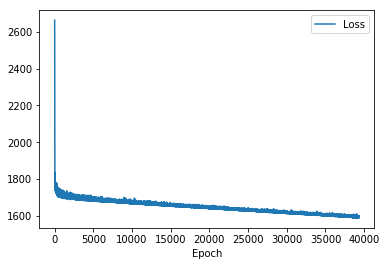

In [13]:
plt.plot(loss_list)
plt.xlabel('Epoch')
plt.legend(['Loss'])


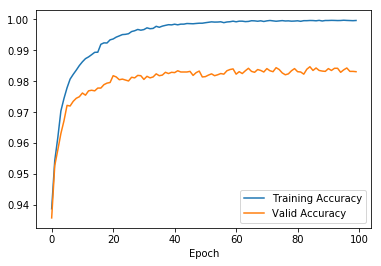

In [14]:
plt.plot(train_acc_list)
plt.plot(valid_acc_list)
plt.xlabel('Epoch')
plt.legend(['Training Accuracy', 'Valid Accuracy'])
plt.show()

In [15]:
# Test Accuracy/ test Error
# We draw 100 samples from the variational distribution to compute the predictive posterior distribution using Monte Carlo Integration

np_probs = np.zeros((len(test_y), 10)) # to store the output of the network for the test examples

mc_steps = 100
for _ in range(mc_steps):
    np_probs += sess.run(predict, feed_dict={x: test_x})

np_probs /= mc_steps

test_acc = np.mean(np.argmax(np_probs,1) == np.argmax(test_y,1))*100

print('test Accuracy=', test_acc)

test Accuracy= 98.50999999999999


References:

- Blundell, Charles, et al. "Weight uncertainty in neural networks." arXiv preprint arXiv:1505.05424 (2015).

